<a href="https://colab.research.google.com/github/FlamingoLindo/Deep-Learnig-COVID-19-Radiography/blob/main/deep_learnig_covid_19_radiography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
! git clone https://github.com/FlamingoLindo/Deep-Learnig-COVID-19-Radiography.git

fatal: destination path 'Deep-Learnig-COVID-19-Radiography' already exists and is not an empty directory.


In [ ]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64
def get_pathframe(base_path):
    '''
    Generates a DataFrame with file paths and categories
    from subdirectories.
    '''
    categories = {
        "COVID": 0,
        "Lung_Opacity": 1,
        "Normal": 2,
        "Viral Pneumonia": 3
    }

    file_paths = []
    file_categories = []

    # Traverse subdirectories
    for category, label in categories.items():
        category_path = os.path.join(base_path, category)
        for filename in os.listdir(category_path):
            file_paths.append(os.path.join(category_path, filename))
            file_categories.append(label)

    df = pd.DataFrame({
        'paths': file_paths,
        'category': file_categories
    })
    return df

In [ ]:
df=get_pathframe("/content/Deep-Learnig-COVID-19-Radiography/Dataset/")
df.tail(5)

,paths,category
21160,/content/Deep-Learnig-COVID-19-Radiography/Dat...,3
21161,/content/Deep-Learnig-COVID-19-Radiography/Dat...,3
21162,/content/Deep-Learnig-COVID-19-Radiography/Dat...,3
21163,/content/Deep-Learnig-COVID-19-Radiography/Dat...,3
21164,/content/Deep-Learnig-COVID-19-Radiography/Dat...,3


In [ ]:
def load_and_preprocess_image(path):
  '''
  Carrega cada imagem e redimensiona para o formato desejado
  '''
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0  # normalize to [0,1] range
  return image

def convert_to_tensor(df):
  '''
  Converte cada dado e rótulo em um tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)

  return image_ds,label_ds

In [ ]:
X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [ ]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000)
dataset_train=dataset.take(22500)
dataset_test=dataset.skip(22500)

dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int64, name=None))>

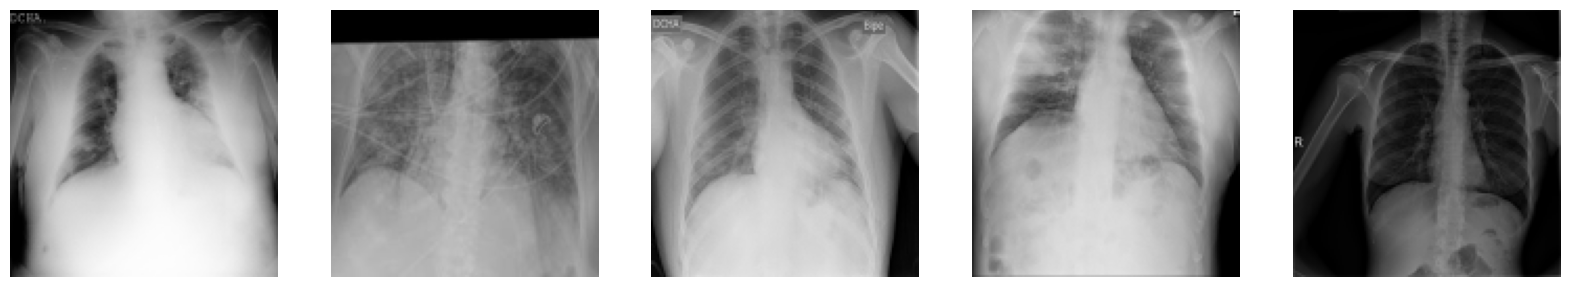

In [ ]:
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[]
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)

In [ ]:
def My_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid')) # softmax

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy'])

  return model

In [ ]:
model=My_CNNmodel()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,103,697 (8.02 MB)

 Trainable params: 2,103,697 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(dataset_train, epochs=10, validation_data=dataset_test)

Epoch 1/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 75s 208ms/step - accuracy: 0.6478 - loss: -9225001.0000
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


330/330 ━━━━━━━━━━━━━━━━━━━━ 78s 204ms/step - accuracy: 0.3537 - loss: 119210280.0000
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 71s 206ms/step - accuracy: 0.3540 - loss: 1741972480.0000
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.3531 - loss: 9439597568.0000
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 72s 208ms/step - accuracy: 0.3541 - loss: 31727306752.0000
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 81s 205ms/step - accuracy: 0.3543 - loss: 81548255232.0000
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 79s 233ms/step - accuracy: 0.3543 - loss: 175789932544.0000
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 71s 206ms/step - accuracy: 0.3543 - loss: 334800027648.0000
Epoch 9/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 90s 232ms/step - accuracy: 0.3545 - loss: 581359304704.0000
Epoch 10/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 74s 205ms/step - accuracy: 0.3536 - loss: 939709366272.0000


In [ ]:
model.save("my_model.keras")

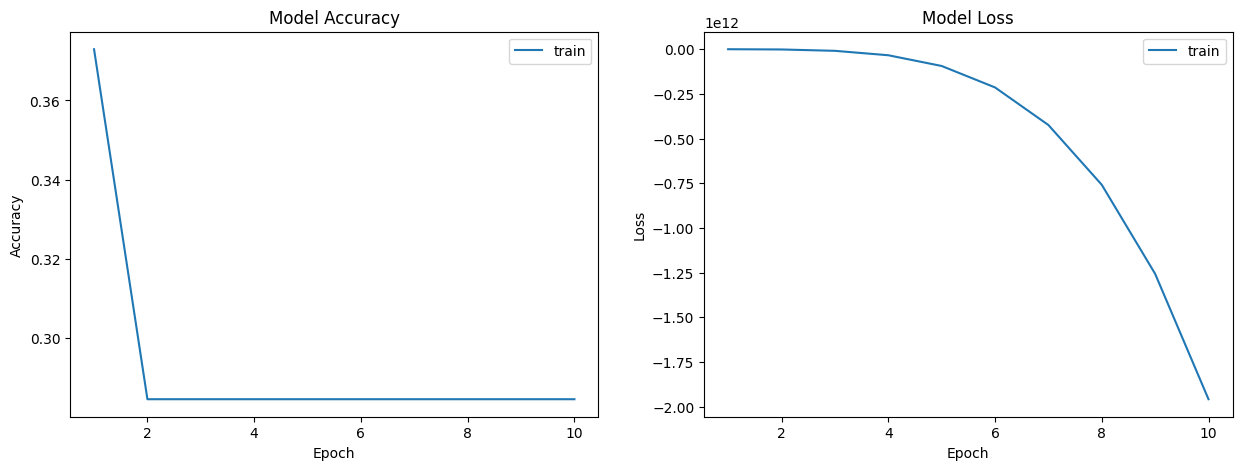

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    if val_acc in model_history.history:
        axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'] if val_acc in model_history.history else ['train'], loc='best')

    # Plot loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    if 'val_loss' in model_history.history:
        axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'] if 'val_loss' in model_history.history else ['train'], loc='best')

    plt.show()

plot_model_history(hist)

In [ ]:
tf.keras.layers.Dropout(0.5)

<Dropout name=dropout_3, built=False>

In [ ]:
tf.keras.layers.BatchNormalization()

<BatchNormalization name=batch_normalization_3, built=False>

In [ ]:
# Predict the values from the validation dataset
loss, accuracy = model.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
y_pred =  model.predict(dataset_test)
y_p = np.where(y_pred > 0.5, 1,0)
test_data=dataset_test.unbatch()
y_g=[]
for image, label in  test_data:
  y_g.append(label.numpy())

confusion_mtx = confusion_matrix(y_g, y_p)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax,
            xticklabels=["Gatos", "Cachorros"], yticklabels=["Gatos", "Cachorros"])
plt.xlabel("Rótulo Previsto")
plt.ylabel("Rótulo Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

ValueError: math domain error

In [ ]:
report = classification_report(y_g, y_p, target_names=['Gatos','Cachorros'])
print(report)